In [1]:
from __future__ import unicode_literals
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date as dt, timedelta
from typing import List
from google.cloud import firestore
from functools import reduce
import time
import base64
import sys
import math


In [2]:
%env GOOGLE_APPLICATION_CREDENTIALS="/Users/marcelcanhisares/Development/tcc/keys/mc-tcc1-2893283b8dce.json"

env: GOOGLE_APPLICATION_CREDENTIALS="/Users/marcelcanhisares/Development/tcc/keys/mc-tcc1-2893283b8dce.json"


In [4]:
%ls /Users/marcelcanhisares/Development/tcc/keys/

mc-tcc1-2893283b8dce.json


In [3]:
DB = firestore.Client.from_service_account_json("/Users/marcelcanhisares/Development/tcc/keys/mc-tcc1-2893283b8dce.json")

In [4]:
collection = DB.collection('analytics').stream()

In [6]:
resultDicts = []
for document in collection:
    resultDicts.append(document.to_dict())
    

In [7]:
resultDicts[0]['date']

'2020-04-23'

In [8]:
resultlist = []
for result in resultDicts:
    if result['date'] == '2020-04-23' or result['date'] == '2020-04-24' or result['date'] == '2020-04-30': continue
    resultlist.append({'Resultados': result['totalResults'], 'Colisões': result['totalCollisions'], 'Data': result['date'] })
df = pd.DataFrame(resultlist)
df['Data'] = pd.to_datetime(df['Data'])

In [9]:
df.set_index('Data', inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 141 entries, 2020-05-01 to 2020-10-13
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Resultados  141 non-null    int64
 1   Colisões    141 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB


In [10]:
df

,Resultados,Colisões
Data,,
2020-05-01,1338,302
2020-05-02,679,312
2020-05-03,410,199
2020-05-04,273,81
2020-05-05,1194,385
...,...,...
2020-12-02,1710,643
2020-12-03,1515,500
2020-12-04,1807,504


In [29]:
temp_line = df
temp_line['Coletados'] = temp_line['Resultados'].sub(temp_line['Colisões'], axis = 0) 

In [30]:
temp_line = temp_line['Coletados']
temp_line

Data
2020-05-01    1036
2020-05-02     367
2020-05-03     211
2020-05-04     192
2020-05-05     809
              ... 
2020-12-02    1067
2020-12-03    1015
2020-12-04    1303
2020-12-05    1109
2020-12-06     306
Name: Coletados, Length: 195, dtype: int64

Text(0, 0.5, 'Tweets')

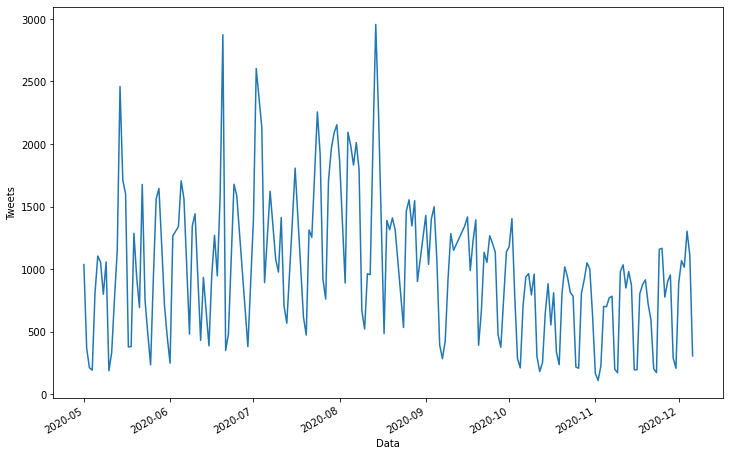

In [34]:
%matplotlib inline
ax = temp_line.plot(figsize=(12,8))
ax.set_ylabel('Tweets')

In [19]:
temp = df

In [21]:
temp = temp.resample('M').sum()
temp['Coletados'] = temp['Resultados'].sub(temp['Colisões'], axis = 0) 

In [22]:
temp

,Resultados,Colisões,Coletados
Data,,,
2020-05-31,40598,12464,28134
2020-06-30,35493,12274,23219
2020-07-31,56493,20732,35761
2020-08-31,56827,20787,36040
2020-09-30,38539,12445,26094
2020-10-31,31700,10080,21620
2020-11-30,28005,9342,18663
2020-12-31,8553,2864,5689


In [14]:
import matplotlib.dates as mdates

In [15]:
temp.index

DatetimeIndex(['2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Data', freq='M')

In [16]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [17]:
%matplotlib tk

In [24]:
# %matplotlib inline

fig, ax = plt.subplots(figsize=(15,10))
width = 12
shift = pd.to_timedelta('12D')
results = ax.bar(temp.index, temp["Coletados"], width=width, label='Resultados')
# colisions = ax.bar(temp.index+shift, temp["Colisões"], width=width, label='Colisões')
ax.legend()
ax.set_xticks(temp.index)
ax.set_title("Tweets coletados por data")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))
autolabel(results)
fig.tight_layout()

plt.show()



In [35]:
df.sum()

Resultados    296208
Colisões      100988
Coletados     195220
dtype: int64

In [36]:
dfs = []
for result in resultDicts:
    t_df = pd.DataFrame(result['results'].items())
    t_df['date'] = result['date']
    t_df.rename(columns={ t_df.columns[0]: "STOCK" }, inplace = True)
    t_df = t_df.pivot(index ='date', columns ='STOCK')
    dfs.append(t_df)

In [60]:
df = pd.concat(dfs)

In [61]:
df.columns = df.columns.get_level_values(1)

In [62]:
pd.options.display.max_rows = 4000

In [ ]:
df

In [69]:
checks = df


In [75]:
mins = []
for column in list(checks.columns):
    mins.append({'stock': column, 'min': checks[column].min()})

In [84]:
min_df = pd.DataFrame(data=mins)
min_df.set_index('stock', inplace=True)
min_df.head()

,min
stock,
ABCB4,0.0
ABEV3,0.0
AGRO3,0.0
ALPA3,0.0
ALPA4,0.0


In [86]:
min_df.loc[min_df['min'] > 0]

,min
stock,
BBAS3,1.0
ITSA4,3.0
ITUB4,2.0
MRFG3,1.0
OIBR3,6.0
PETR4,4.0
VALE3,2.0


In [ ]:
sum_df = df.select_dtypes(np.number).sum()

In [41]:
sum_df.sum()

223161.0

In [ ]:
sum_df.where

In [58]:
bigs = sum_df
cods = list(bigs.index)
cods

['OIBR3',
 'PETR4',
 'MGLU3',
 'VALE3',
 'BBDC4',
 'EMBR3',
 'CIEL3',
 'JHSF3',
 'BBAS3',
 'MRFG3']

In [56]:
n = sum_df.nsmallest(10)
n.index

Index(['BRGE11', 'NAFG4', 'BMIN4', 'PATI3', 'CSRN5', 'BMEB3', 'BRGE3', 'CALI4',
       'ISUS11', 'TCNO4'],
      dtype='object', name='STOCK')

In [28]:
%matplotlib tk

In [48]:
acoes = ["VALE3","ITUB4","B3SA3","PETR4","BBDC4","PETR3","ABEV3","BBAS3","MGLU3","ITSA4","WEGE3","JBSS3","LREN3","GNDI3","NTCO3","SUZB3","RENT3","BBDC3","EQTL3","RADL3","RAIL3","VVAR3","LAME4","BTOW3","UGPA3","VIVT4","SBSP3","BBSE3","CCRO3","BRFS3","GGBR4","BRDT3","BPAC11","KLBN11","HAPV3","HYPE3","SULA11","COGN3","ENGI11","TIMP3","ELET3","CSAN3","PCAR3","EGIE3","CMIG4","SANB11","YDUQ3","TOTS3","BRML3","IRBR3","ELET6","QUAL3","BRAP4","CRFB3","FLRY3","CSNA3","CYRE3","AZUL4","BRKM5","TAEE11","EMBR3","MULT3","MRVE3","CIEL3","ENBR3","CPFE3","MRFG3","GOAU4","USIM5","BEEF3","IGTA3","CVCB3","GOLL4","ECOR3","HGTX3"]

In [54]:
colunas = list(df.columns)
for cod in acoes:
    if cod not in colunas:
        print(cod)    

B3SA3
GNDI3
NTCO3
SUZB3
BBDC3
VVAR3
BRDT3
BPAC11
HAPV3
COGN3
PCAR3
EGIE3
YDUQ3
IRBR3
CRFB3


In [29]:
sum_df = sum_df.rename_axis('Ativo')

In [31]:
my_colors = [(x/50, x/100, 0.75) for x in range(len(sum_df.nlargest(10)))]
fig = sum_df.nlargest(10).plot.bar(rot=90, y='Count', x='Ativo', figsize=(10,5), color=my_colors, title="Menções por ativo", fontsize=10)
fig.set_title('Menções por ativo', fontdict = {'fontsize' : 15})
fig.set_xlabel('Ativo', fontsize=15)
fig.set_ylabel('Menções', fontsize=15)

Text(47.5, 0.5, 'Menções')

In [32]:
fig.plot()

[]

In [24]:
sum_df.nlargest(30)

Ativo
OIBR3     14984.0
PETR4      9518.0
MGLU3      6574.0
BBDC4      6150.0
JHSF3      5769.0
VALE3      5647.0
BBAS3      4979.0
MRFG3      4571.0
CIEL3      4149.0
ITUB4      4049.0
BEEF3      3964.0
AZUL4      3710.0
ITSA4      3710.0
EVEN3      3193.0
WEGE3      3070.0
EMBR3      2939.0
JBSS3      2580.0
GOLL4      2467.0
SHOW3      2333.0
CVCB3      2052.0
BTOW3      2016.0
OIBR4      1926.0
PETR3      1863.0
RAPT3      1790.0
RENT3      1760.0
CSNA3      1606.0
ABEV3      1582.0
GGBR4      1571.0
BOVA11     1524.0
ELET3      1512.0
dtype: float64

In [25]:
collection = DB.collection('tweets').stream()

In [26]:
count = 0
date_dict = dict()
dates = []
for tweet in collection:
    date = tweet.to_dict()['date'].strftime('%Y-%m-%d')
    date_dict[date] = date_dict[date] + 1 if date in date_dict else 1
    count = count + 1

DeadlineExceeded: 504 Deadline Exceeded

In [ ]:
date_dict